In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import interact, fixed
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

from src.preprocessing import parse_data, split_train_test
from src.training import trainer
from src.models import LSTM, LSTMAtt, CNN, LSTMPlus, Transformer
from src.evaluation import eval_model, get_saliencies2, vizualize_saliency, test_attack
from src.plotting import plot_saliency_eps, plot_saliency_heatmap

# Project tasks

# 1. Choose a dataset and train LSTM, LSTMAtt, CNN models.

We have chosen `ItalyPowerDemand` dataset form the provided [catalog](https://www.timeseriesclassification.com/description.php?Dataset=ItalyPowerDemand). 

This dataset consists of 67 time series of length 24, corresponding to hourly power demand. One time series if one day. The task is to destinguish between October to March (inclusive) from April to September.

## 1.1. Load data

In [3]:
seed = 31337

In [4]:
data_np, labels_np = parse_data()

In [5]:
data_np.shape, labels_np.shape

((67, 24, 1), (67,))

In [6]:
df_train_features, df_val_features, df_train_labels, df_val_labels = \
    *(torch.from_numpy(d) for d in train_test_split(data_np, labels_np, 
                                                    stratify=labels_np, random_state=seed)),

In [7]:
df_train_features.shape

torch.Size([50, 24, 1])

In [8]:
print(df_train_features.shape, df_train_labels.shape, df_val_features.shape, df_val_labels.shape)

torch.Size([50, 24, 1]) torch.Size([50]) torch.Size([17, 24, 1]) torch.Size([17])


In [9]:
torch.unique(df_train_labels, return_counts=True)

(tensor([0, 1]), tensor([25, 25]))

In [10]:
torch.unique(df_val_labels , return_counts=True)

(tensor([0, 1]), tensor([8, 9]))

## 1.2 Training

In [11]:
n_epochs = 500
tolerance = 100
freq_print = 10

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### 1.2.1. LSTM

In [13]:
lstm_model = LSTM(1, 10, 1, 2).to(device)

In [14]:
device

'cuda:0'

In [15]:
lstm_model = trainer(
    model=lstm_model,
    n_epochs=n_epochs,
    X_train=df_train_features,
    y_train=df_train_labels,
    X_val=df_val_features,
    y_val=df_val_labels,
    lr=1e-3,
    device=device,
    tolerance=tolerance,
    freq_print=freq_print,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch = 9, 	Loss = 0.7078012228012085, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 19, 	Loss = 0.7055280804634094, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 29, 	Loss = 0.7023613452911377, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 39, 	Loss = 0.6995862722396851, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 49, 	Loss = 0.6964158415794373, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 59, 	Loss = 0.6932116150856018, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 69, 	Loss = 0.690238356590271, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 79, 	Loss = 0.6884583234786987, 	Training_acc = 0.6599999999999999, 	Validation_acc = 0.6875
Epoch = 89, 	Loss = 0.683402419090271, 	Training_acc = 0.7, 	Validation_acc = 0.6875
Epoch = 99, 	Loss = 0.6793954968452454, 	Training_acc = 0.7, 	Validation_acc = 0.6875
Epoch = 109, 	Loss = 0.6720437407493591, 	Training_acc = 0.6599999999999999, 	Validation_acc = 0.7569444444444444
Epoch = 119, 	Loss = 0.663749694824

### 1.2.2. LSTMAtt

In [16]:
#lstmatt_model = LSTMAtt(1, 30, 1, 2).to(device)
lstmatt_model = LSTMPlus(input_size=1, 
                         hidden_size=30,
                         r=20,
                         d_a=50,
                         num_classes=2).to(device)

In [17]:
lstmatt_model = trainer(
    model=lstmatt_model,
    n_epochs=n_epochs,
    X_train=df_train_features,
    y_train=df_train_labels,
    X_val=df_val_features,
    y_val=df_val_labels,
    lr=1e-3,
    device=device,
    tolerance=tolerance*2,
    freq_print=freq_print,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch = 9, 	Loss = 0.6931477189064026, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 19, 	Loss = 0.6929270029067993, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 29, 	Loss = 0.6928380727767944, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 39, 	Loss = 0.6886580586433411, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 49, 	Loss = 0.6743100881576538, 	Training_acc = 0.56, 	Validation_acc = 0.625
Epoch = 59, 	Loss = 0.6851662993431091, 	Training_acc = 0.64, 	Validation_acc = 0.6875
Epoch = 69, 	Loss = 0.6481212377548218, 	Training_acc = 0.78, 	Validation_acc = 0.7083333333333333
Epoch = 79, 	Loss = 0.6422698497772217, 	Training_acc = 0.64, 	Validation_acc = 0.6319444444444444
Epoch = 89, 	Loss = 0.6785514950752258, 	Training_acc = 0.8200000000000001, 	Validation_acc = 0.7777777777777778
Epoch = 99, 	Loss = 0.6617721319198608, 	Training_acc = 0.8, 	Validation_acc = 0.7222222222222222
Epoch = 109, 	Loss = 0.6165668964385986, 	Training_acc = 0.76, 	Validation_acc = 0.7013

### 1.2.3. CNN

In [18]:
df_train_features_cnn = df_train_features.transpose(1, 2)
df_val_features_cnn = df_val_features.transpose(1, 2)

In [19]:
cnn_model = CNN(2).to(device)

In [20]:
cnn_model = trainer(
    model=cnn_model,
    n_epochs=n_epochs,
    X_train=df_train_features,
    y_train=df_train_labels,
    X_val=df_val_features,
    y_val=df_val_labels,
    device=device,
    tolerance=tolerance,
    freq_print=freq_print,
)

  0%|          | 0/500 [00:00<?, ?it/s]

/home/alex/anaconda3/envs/impdirs/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch = 9, 	Loss = 0.6071441173553467, 	Training_acc = 0.52, 	Validation_acc = 0.5555555555555556
Epoch = 19, 	Loss = 0.5073437690734863, 	Training_acc = 0.98, 	Validation_acc = 1.0
Epoch = 29, 	Loss = 0.4540972113609314, 	Training_acc = 0.98, 	Validation_acc = 1.0
Epoch = 39, 	Loss = 0.4239318072795868, 	Training_acc = 1.0, 	Validation_acc = 1.0
Epoch = 49, 	Loss = 0.40725964307785034, 	Training_acc = 1.0, 	Validation_acc = 1.0
Epoch = 59, 	Loss = 0.3774632215499878, 	Training_acc = 1.0, 	Validation_acc = 1.0
Epoch = 69, 	Loss = 0.3792645335197449, 	Training_acc = 0.98, 	Validation_acc = 1.0
Epoch = 79, 	Loss = 0.3719090223312378, 	Training_acc = 1.0, 	Validation_acc = 1.0
Epoch = 89, 	Loss = 0.3733620345592499, 	Training_acc = 1.0, 	Validation_acc = 1.0
Epoch = 99, 	Loss = 0.37223225831985474, 	Training_acc = 1.0, 	Validation_acc = 1.0
Epoch = 109, 	Loss = 0.36877119541168213, 	Training_acc = 0.98, 	Validation_acc = 1.0
Best validation accuracy is: 1.0


In [21]:
trans_model = Transformer(num_inputs=1, embed_dim=32, num_heads=2, num_classes=2)

In [22]:
trans_model = trainer(
    model=trans_model,
    n_epochs=n_epochs,
    X_train=df_train_features,
    y_train=df_train_labels,
    X_val=df_val_features,
    y_val=df_val_labels,
    device=device,
    tolerance=tolerance,
    freq_print=freq_print,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch = 9, 	Loss = 0.6929296851158142, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 19, 	Loss = 0.6924532055854797, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 29, 	Loss = 0.6906724572181702, 	Training_acc = 0.6799999999999999, 	Validation_acc = 0.6875
Epoch = 39, 	Loss = 0.6818364858627319, 	Training_acc = 0.76, 	Validation_acc = 0.7569444444444444
Epoch = 49, 	Loss = 0.673997700214386, 	Training_acc = 0.78, 	Validation_acc = 0.8194444444444444
Epoch = 59, 	Loss = 0.6610161066055298, 	Training_acc = 0.74, 	Validation_acc = 0.8194444444444444
Epoch = 69, 	Loss = 0.6270601153373718, 	Training_acc = 0.76, 	Validation_acc = 0.875
Epoch = 79, 	Loss = 0.6004863381385803, 	Training_acc = 0.84, 	Validation_acc = 1.0
Epoch = 89, 	Loss = 0.5810859799385071, 	Training_acc = 0.88, 	Validation_acc = 1.0
Epoch = 99, 	Loss = 0.5403148531913757, 	Training_acc = 0.9199999999999999, 	Validation_acc = 1.0
Epoch = 109, 	Loss = 0.5132260322570801, 	Training_acc = 0.94, 	Validation_acc = 1.0
E

## 1.3. Evaluation

In [23]:
data_test_np, labels_test_np = parse_data(data_path='./data/ItalyPowerDemand_TEST.ts')
df_test = torch.from_numpy(data_test_np)
labels_test = torch.from_numpy(labels_test_np)

In [24]:
_ = eval_model(model_name="LSTM", model=lstm_model, X_test=df_test, y_test=labels_test, device=device)

LSTM test accuracy = 0.9211829638696224


In [25]:
_ = eval_model(model_name="LSTM with Attention", model=lstmatt_model, X_test=df_test, y_test=labels_test, device=device)

LSTM with Attention test accuracy = 0.8259667255995284


In [26]:
_ = eval_model(model_name="CNN", model=cnn_model, X_test=df_test, y_test=labels_test, device=device)

CNN test accuracy = 0.8928498572011423


In [27]:
_ = eval_model(model_name="Transformer", model=trans_model, X_test=df_test, y_test=labels_test, device=device)

Transformer test accuracy = 0.7991806065551476


# 2. Saliency

Evaluate saliencies for the models. Calculate saliencies for each time series element and aggregate for all the data.

In [28]:
y_true = labels_test.detach().numpy()
idx_test_sorted = np.argsort(y_true)

In [29]:
names = ("LSTM", "LSTMAtt", "CNN", "Transformer")
models = (lstm_model, lstmatt_model, cnn_model, trans_model)

In [30]:
saliencies = {k: get_saliencies2(
    model=m, X=df_test, y=labels_test, device=device
) for k, m in zip(names, models)}

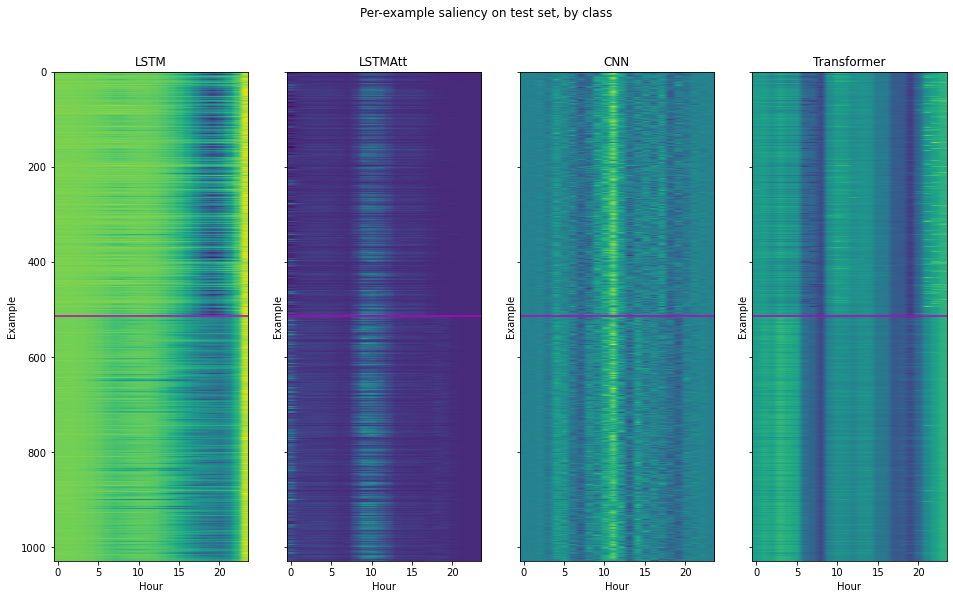

In [31]:
fig, ax = plt.subplots(1, len(models), sharex=False, sharey=True, figsize=(16, 9), dpi=72)
fig.suptitle("Per-example saliency on test set, by class")

for i, (n, s) in enumerate(saliencies.items()):
    ax[i].set_title(n)
    plot_saliency_heatmap(s, y_true, ax=ax[i])

plt.show()

### Analysis
We can see that for class label `0` (April-Septembe, top part) consumption at times around 6 AM is the least important, while times around noon are the most important.

### Per-example visuals

In [32]:
for _ in range(3):
    continue
    i = np.random.randint(low=0, high=len(df_test), )
    print(i)
    vizualize_saliency(
        df=df_test,
        labels=labels_test,
        index_=i,
        saliencies_0=saliencies_0,
        saliencies_1=saliencies_1,
        preds=preds_test,
    )

# 3. FGSM attack

Investigate the FGSM attack’s influence on the models: visualize the models’ quality decrease during the attack.

### FGSM attack (CNN)

In [33]:
#epsilons = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
epsilons = np.linspace(0, 0.4, 100)

accuracies_dict = {}
perturbed_data_dict = {}
predicted_label_dict = {}
saliency_dict = {}

for name, model in zip(names, models):
    accuracies_eps = np.zeros((len(epsilons), ))
    perturbed_data_eps = np.zeros((len(epsilons), len(labels_test), 24, 1))
    predicted_label_eps = np.zeros((len(epsilons), len(labels_test)))
    saliency_eps = np.zeros((len(epsilons), len(labels_test), 24))
    
    #print(f"Model {name=}")

    for i, eps in tqdm(enumerate(epsilons), total=len(epsilons), desc=name):
        acc, perturbed_data, predicted_labels = \
            test_attack(model=model, data_=df_test, labels_=labels_test, epsilon=eps, device=device)
        accuracies_eps[i] = acc
        #print(perturbed_data.shape, predicted_labels.shape)
        perturbed_data_eps[i] = perturbed_data
        predicted_label_eps[i] = predicted_labels

        perturbed_data_tensor = torch.tensor(perturbed_data)

        saliency_eps[i] = get_saliencies2(
            model=model,
            X=perturbed_data_tensor,
            y=labels_test,
            device=device
        )
    
    accuracies_dict[name] = accuracies_eps
    perturbed_data_dict[name] = perturbed_data_eps
    predicted_label_dict[name] = predicted_label_eps
    saliency_dict[name] = saliency_eps

LSTM:   0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'get_saliencies' is not defined

## 3.1. Visualize the models’ quality decrease during the attack

In [ ]:
colors = {n: f"C{i}" for i, n in enumerate(accuracies_dict.keys())}
colors

In [ ]:
#list(accuracies_dict.items())

In [ ]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 9), dpi=72)
plt.suptitle("FGSM attack on test set")

# Special scale for LSTMAtt
ax11 = ax[1].twinx()
ax21 = ax[2].twinx()
ax11.set_ylabel("Average Mean saliency (LSTMAtt)")
ax21.set_ylabel("Average Max saliency (LSTMAtt)")

h = [[], [], []]
for name in accuracies_dict.keys():
    p1, = ax[0].plot(epsilons, accuracies_dict[name], 
               c=colors[name], label=name)
    p2, = (ax11 if name == "LSTMAtt" else ax[1]).\
        plot(epsilons, saliency_dict[name].mean(axis=-1).mean(axis=-1), 
               c=colors[name], label=name)
    p3, = (ax21 if name == "LSTMAtt" else ax[2]).\
        plot(epsilons, saliency_dict[name].max(axis=-1).mean(axis=-1), 
               c=colors[name], label=name)
    h[0].append(p1)
    h[1].append(p2)
    h[2].append(p3)

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Average Mean saliency")
ax[2].set_ylabel("Average Max saliency")

for i, ax_ in enumerate(ax):
    ax_.set_xlabel("Epsilon")
    ax_.legend(handles=h[i])

plt.tight_layout()
plt.show()

In [ ]:
interact(plot_saliency_eps, 
         model=list(names),
         idx=(0, len(labels_test), 1),
         epsilons=fixed(epsilons),
         saliency_dict=fixed(saliency_dict), 
         predicted_label_dict=fixed(predicted_label_dict),
         true_labels=fixed(labels_test))

We see that with increase of the attack intensity saliency gradually drops for some of the test examples.

In [ ]:
#saliency_dict["CNN"].shape